# Hats Riddle


_In a jail there are 100 prisoners that behaved well in the last year. The
  jail chief decides to test their social abilities of cooperation and to release
  the prisoners who prove to be good teammates. In order to do so, he
  communicates the following task to the prisoners. Next morning, all 100
  prisoners will be placed in a random ordered row in such a way that the
  first prisoner will clearly see the other 99, the second one will see only the
  following 98 and so on. After that, on each of their heads will be placed
  a hat of a random color, blue or red, but they will only know the colors
  of the prisoner’s hats in front of them (they won’t know the color of their
  own hat or the colors of the hats behind them)._
 
_Starting with the prisoner that can see all the others and going one by
  one till the last prisoner which can not see anybody, they will need to
  guess what is the color of their own hat. Their guesses will be heard by
  all the other prisoners and if the guess is correct, then the guesser will be
  released, otherwise he will be send back in his cell._

_The prisoners are left overnight to come up with a strategy of how they
  should behave the next morning in order to maximize the number of those
  who will be released._

<sup>Text inspired from the problem _Red and Blue hats, Version II_, P. Winkler, Mathematical Puzzles: A Connoisseur’s Collection, A.K.Peters, 2004.</sup>


Architecture, methodology and notations inspired from the paper [Learning to Communicate to Solve Riddles with Deep Distributed Recurrent Q-Networks](https://www.semanticscholar.org/paper/Learning-to-Communicate-to-Solve-Riddles-with-Deep-Foerster-Assael/52cb696af18aad0383770071d150137c39404edf).

In [1]:
from keras.layers import Input, Add, Embedding, LSTM, Dense
from keras.layers import Reshape, Concatenate
from keras.models import Model

Using TensorFlow backend.


In [2]:
number_of_agents = 4

Using the notations from the article we first declare: $a^k, s^k$ (inputs of the actions/hats observed by each agent) and $m, n$ (the index of each agent and the total number of agents).

In [3]:

#a^k
action_inputs      = [Input(shape=(1,), dtype='float32', name='action_inputs_' + str(i))\
                      for i in range(number_of_agents - 1)]
#tf.placeholder(tf.float64, shape=(1, 1))

#s^k
observation_inputs = [Input(shape=(1,), dtype='float32', name='observation_inputs_' + str(i))\
                      for i in range(number_of_agents - 1)]
#tf.placeholder(tf.float64, shape=(1, 1))

#(m, n)
index_inputs       = Input(shape=(2,), dtype='float32', name='index_inputs')

Now we define $z^k_a$ and $z^k_s$, the output of the MLPs which will be feeded to the LSTM network.

In [4]:
index_mlp          = Dense(64, activation='relu', name="index_mlp")(index_inputs)
#z_a^k
action_mlps        = [Dense(64, activation='relu')(action_input) \
                      for action_input in action_inputs]
action_lstm_inputs = [Add()([action_mlp, index_mlp]) \
                      for action_mlp in action_mlps]


#z_s^k
observation_mlps        = [Dense(64, activation='relu')(observation_input)\
                           for observation_input in observation_inputs]
observation_lstm_inputs = [Add()([observation_mlp, index_mlp])\
                           for observation_mlp in observation_mlps]

Now we define the LSTMs with the outputs $y_a^k, h_a^k$ and $y_s^k, h_s^k$ which will be passed to another MLP
to predict the final decision. 

In [5]:
#actions lstm construction

#reshape the output of the dense layer in order to be a sequence of 64 inputs
action_lstm_inputs_block   = Reshape((-1,64), name="action_lstm_inputs")(Concatenate(axis=1)(action_lstm_inputs))
action_lstm                = LSTM(64, name="action_lstm")(action_lstm_inputs_block)

#same approach for the observations lstm
observation_lstm_inputs_block = Reshape((-1,64), name="observation_lstm_inputs")(Concatenate(axis=1)(observation_lstm_inputs))
observation_lstm              = LSTM(64, name="observation_lstm")(observation_lstm_inputs_block)

Now we create the last part of the model. We feed the output of the LSTMs to an MLP in order to get the predictions $Q^m, m \in [1, n]$.

In [6]:
prediction_inputs  = Concatenate(axis=1, name="prediction_inputs")([action_lstm, observation_lstm])

prediction_layer_1 = Dense(64, activation='relu', name="prediction_layer_1")(prediction_inputs)
prediction_layer_2 = Dense(64, activation='relu', name="prediction_layer_2")(prediction_layer_1)
prediction_output  = Dense(1, activation='relu', name="prediction_output")(prediction_layer_2)

prediction_output

<tf.Tensor 'prediction_output/Relu:0' shape=(?, 1) dtype=float32>

Assemble all layers into a model:

In [7]:
model = Model(inputs=action_inputs + observation_inputs + [index_inputs],\
              outputs=[prediction_output])

The architecture in the [paper](https://www.semanticscholar.org/paper/Learning-to-Communicate-to-Solve-Riddles-with-Deep-Foerster-Assael/52cb696af18aad0383770071d150137c39404edf) looks like this:


![](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/52cb696af18aad0383770071d150137c39404edf/5-Figure3-1.png)
<!--img src="5-Figure3-1.png"-->

In keras, the architecture is as follows:

In [8]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
action_inputs_0 (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
index_inputs (InputLayer)       (None, 2)            0                                            
__________________________________________________________________________________________________
action_inputs_1 (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
action_inputs_2 (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
observatio

### Checkpoint

Entire model generation function:

In [1]:
from keras.layers import GRU
from keras.layers import Input, Add, Embedding, LSTM, Dense
from keras.layers import Reshape, Concatenate
from keras.models import Model
from keras.optimizers import Nadam
from keras.initializers import RandomNormal
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Activation

def generate_model(number_of_agents):
    bias_initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)
    activation = 'tanh'#Activation('tanh')#LeakyReLU()
    #a^k
    action_inputs      = [Input(shape=(1,), dtype='float32', name='action_inputs_' + str(i))\
                          for i in range(number_of_agents - 1)]
    #s^k
    observation_inputs = [Input(shape=(1,), dtype='float32', name='observation_inputs_' + str(i))\
                          for i in range(number_of_agents - 1)]
    #(m, n)
    index_inputs       = Input(shape=(2,), dtype='float32', name='index_inputs')

    index_mlp          = Dense(64, activation=activation, bias_initializer=bias_initializer, name="index_mlp")(index_inputs)
    #z_a^k
    action_mlps        = [Dense(64, activation=activation, bias_initializer=bias_initializer)(action_input) \
                          for action_input in action_inputs]
    action_lstm_inputs = [Add()([action_mlp, index_mlp]) \
                          for action_mlp in action_mlps]


    #z_s^k
    observation_mlps        = [Dense(64, activation=activation, bias_initializer=bias_initializer)(observation_input)\
                               for observation_input in observation_inputs]
    observation_lstm_inputs = [Add()([observation_mlp, index_mlp])\
                               for observation_mlp in observation_mlps]

    #actions lstm construction:
    #reshape the output of the dense layer in order to be a sequence of 64 inputs
    action_lstm_inputs_block   = Reshape((-1,64), name="action_lstm_inputs")(Concatenate(axis=1)(action_lstm_inputs))
    action_lstm                = LSTM(64, activation=activation, bias_initializer=bias_initializer, name="action_lstm")(action_lstm_inputs_block)

    #same approach for the observations lstm
    observation_lstm_inputs_block = Reshape((-1,64), name="observation_lstm_inputs")(Concatenate(axis=1)(observation_lstm_inputs))
    observation_lstm              = LSTM(64, activation=activation, bias_initializer=bias_initializer, name="observation_lstm")(observation_lstm_inputs_block)

    prediction_inputs  = Concatenate(axis=1, name="prediction_inputs")([action_lstm, observation_lstm])

    prediction_layer_1 = Dense(64, activation=activation, bias_initializer=bias_initializer, name="prediction_layer_1")(prediction_inputs)
    prediction_layer_2 = Dense(64, activation=activation, bias_initializer=bias_initializer, name="prediction_layer_2")(prediction_layer_1)
    prediction_output  = Dense(2, activation=activation, bias_initializer=bias_initializer, name="prediction_output")(prediction_layer_2)

    model = Model(inputs=action_inputs + observation_inputs + [index_inputs],\
                  outputs=[prediction_output])
    
    
    rmsprop = Nadam(lr=5 * 10 ** (-4), beta_1=0.95, beta_2=0.999, schedule_decay=0.004)
    model.compile(loss='mean_squared_error', optimizer=rmsprop, )

    return model

Using TensorFlow backend.


To Do:

Test everything goes as expected (i.e. shapes are ok and similar things)

# Data set creation

In [3]:
import numpy as np

Create empty dictionary to store all inputs:

In [4]:
def generate_empty_inputs(number_of_agents):
    input_names = ["index_inputs"] +\
    ["action_inputs_" + str(i) for i in range(number_of_agents - 1)] +\
    ["observation_inputs_" + str(i) for i in range(number_of_agents - 1)]

    inputs                 = {name: np.empty((1, 1))[1:] for name in input_names}
    inputs["index_inputs"] = np.empty((1, 2))[1:]
    return inputs

Make hat distribution

In [5]:
def draw_hats(number_of_agents):
    '''return an array, with 1's and 2's, of length number_of_agents'''
    return [np.random.randint(1, 3) for i in range(number_of_agents)]

def draw_hats_batch(number_of_agents, batch_size):
    '''return an array, of length batch_size, of arrays, with 1's and 2's, of length number_of_agents'''
    return np.random.randint(1, 3, size=(batch_size, number_of_agents))
#[draw_hats(number_of_agents) for i in range(batch_size)]

draw_hats_batch(number_of_agents=4, batch_size=3)

array([[2, 1, 2, 1],
       [1, 1, 1, 2],
       [1, 1, 1, 1]])

Legend:
- Agent indexes are $m \in [1, number\_of\_agents] \cap \mathbb{N}$;
- Colors of hats are $1$ or $2$;
- 0 means only boarding (observations/actions).


In [6]:
#method to be tested and to be added edge cases

def generate_single_input(hats, agent_idx, taken_actions):
    '''
    hats:             the distribution of hats;
    agent_idx:        the agent for which the input is generated;
    taken_actions:    what the agent sayed before, borded with zeros.
    
    len(hats) == len(taken_actions)
    
    e.g.
    generate_input(hats=[1, 2, 1, 1], agent_idx=1, taken_actions=[0, 0, 0, 0])
    '''
    number_of_agents = len(hats)

    inputs = generate_empty_inputs(number_of_agents)

    #record previous actions
    actions = list(taken_actions)[agent_idx:] + [0] * (agent_idx - 1)
    for action, i in zip(taken_actions, range(number_of_agents - 1)):
        input_name         = "action_inputs_" + str(i) 
        inputs[input_name] = np.vstack([inputs[input_name], [action]])

    #record observations
    observations = list(hats)[agent_idx:] + [0] * (agent_idx - 1)
    for observation, i in zip(observations, range(number_of_agents - 1)):
        input_name         = "observation_inputs_" + str(i)
        inputs[input_name] = np.vstack([inputs[input_name], [observation]])

    #record indexes
    inputs["index_inputs"] = np.vstack([inputs["index_inputs"], [agent_idx, number_of_agents]])
    
    return inputs

generate_single_input(np.array([1, 2, 1]), 3, np.array([1, 2, 0]))

{'action_inputs_0': array([[ 1.]]),
 'action_inputs_1': array([[ 2.]]),
 'index_inputs': array([[ 3.,  3.]]),
 'observation_inputs_0': array([[ 0.]]),
 'observation_inputs_1': array([[ 0.]])}

In [7]:
from functools import reduce

def generate_batch_input(hats_batch, agent_idx, previous_actions_batch):
    '''
    calls generate_single_input() for each pair from zip(hats_batch, previous_actions_batch)
    '''
    inputs_list = [generate_single_input(hats, agent_idx, prev_acts) \
                   for hats, prev_acts in zip(hats_batch, previous_actions_batch)]
    inputs = {}
    for name in inputs_list[0]:
        inputs[name] = reduce(lambda x, y: np.vstack((x, y)), [inp[name] for inp in inputs_list]) 
    return inputs

generate_batch_input([[1, 2, 1, 1], [2, 1, 1, 1]], 4, [[1, 2, 1, 0], [2, 1, 2, 0]])

{'action_inputs_0': array([[ 1.],
        [ 2.]]), 'action_inputs_1': array([[ 2.],
        [ 1.]]), 'action_inputs_2': array([[ 1.],
        [ 2.]]), 'index_inputs': array([[ 4.,  4.],
        [ 4.,  4.]]), 'observation_inputs_0': array([[ 0.],
        [ 0.]]), 'observation_inputs_1': array([[ 0.],
        [ 0.]]), 'observation_inputs_2': array([[ 0.],
        [ 0.]])}

# Write episodes flow

In [8]:
def generate_first_agents_hearings(number_of_agents, batch_size):
    return np.zeros((batch_size, number_of_agents))#[[0] * (number_of_agents - 1) for i in range(batch_size)]

generate_first_agents_hearings(number_of_agents=3, batch_size=4)

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [9]:
def generate_hearings_from_predictions(predictions, epsilon):
    hearnings = [prediction.argmax() + 1 if np.random.rand() > epsilon else np.random.randint(1, 3) \
                 for prediction in predictions]
    return np.array(hearnings)

In [10]:
number_of_agents = 3
model = generate_model(number_of_agents)
batch_size   = 20
num_episodes = 10 ** 5
epsilon = .3
average_saved_agents = [number_of_agents / 2] * 20

In [ ]:
import sys

for episode in range(num_episodes):
    hats_batch = draw_hats_batch(number_of_agents=number_of_agents, batch_size=batch_size)

    ### Make guesses:
    #first agents hearings
    past_hearings = generate_first_agents_hearings(number_of_agents=number_of_agents, batch_size=batch_size) 
    model_inputs  = []
    predictions   = []
    for m in range(number_of_agents):
        #predict each agents outcome
        model_inputs.append(generate_batch_input(hats_batch, m + 1, past_hearings))
        predictions.append(model.predict(model_inputs[-1]))
        #e-greedy
#         print(predictions[-1])
        current_hearings = generate_hearings_from_predictions(predictions[-1], epsilon)
        predictions[-1][0][current_hearings[0] - 1] = number_of_agents
#         print(predictions[-1])
        past_hearings[:, m] = current_hearings.flatten()
    #     print(current_hearings)
    #     print(past_hearings)

#     break
    #Validate guesses

    total_rewards = (past_hearings == hats_batch).sum(axis=1) 
    average_over_time = float(round((sum(average_saved_agents[-19:])\
                                     + (sum(total_rewards) / len(total_rewards)))\
                                    /20, 2))
    average_saved_agents.append(average_over_time)
#     print("Hats:", hats_batch)
#     [print(m) for m in model_inputs]
#     print("Agents' predictions:", [list(p[0]) for p in predictions])
#     print("Hearins:", past_hearings)
#     print("Rewards", total_rewards)

    #update model
    for m in range(number_of_agents):
        labels = predictions[m]
        labels[range(len(labels)), labels.argmax(axis=1)] = total_rewards - (number_of_agents / 2)
        inputs=(model_inputs[m])
#         print(labels)
        model.fit(inputs, labels, verbose=0, batch_size=batch_size)
#     break
    if(episode % 100 == 99):
        saved_average = average_saved_agents[-1]
        training_percentage = (episode + 1) / num_episodes * 100
        sys.stdout.write("\rNumber of saved agents after {0:d}, out of {1:d} ({2:.2f}%), episodes is {3:.2f}."\
              .format(episode + 1, num_episodes, training_percentage, saved_average))
    
    if(episode % 1000 == 99):
        epsilon = max(.01, epsilon - .01)

Number of saved agents after 100000, out of 100000 (100.00%), episodes is 1.98.

In [ ]:
np.savetxt("results/statistics/hats_riddle/average_saved_agents_{0:d}"\
           .format(number_of_agents), average_saved_agents)

For training 3 agents (using Q nets), for 100000 episodes,
the number started at: 1.49 and reached: 2.02


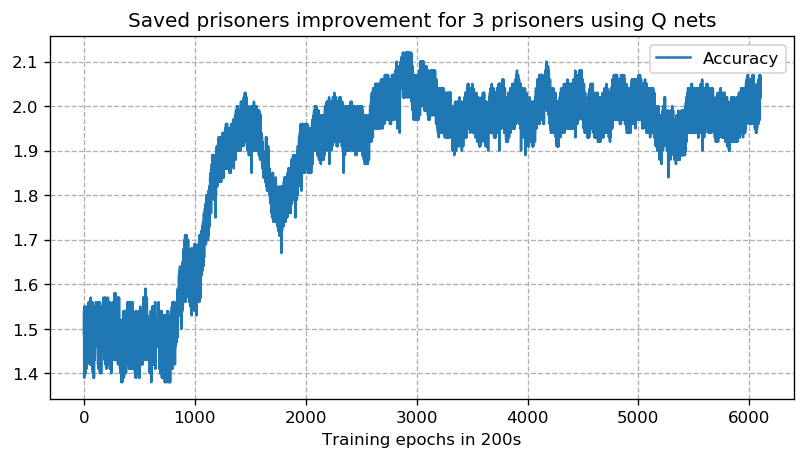

In [421]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_statistics(saved_averages, num_episodes, number_of_agents):
    num_episodes = len(saved_averages)
    batch_accuracy = [sum(saved_averages[i*100: (i+1) * 100]) / 100 for i in range(len(saved_averages) // 100)]
    plt.figure(figsize=(4, 4), dpi= 120)
    plt.axes()
    plt.title("Saved prisoners improvement for {0:d} prisoners using Q nets".format(number_of_agents))
    plt.plot(batch_accuracy, label = "Accuracy")
    plt.yscale("linear")
    plt.xlabel("Training epochs in 200s")
    plt.legend()
    plt.grid(linestyle='--')

    print("For training", number_of_agents, "agents (using Q nets), for", num_episodes, "episodes,")
    print("the number started at:", batch_accuracy[0], "and reached:", batch_accuracy[-1])

plot_statistics(average_saved_agents[1100:], num_episodes, number_of_agents)